### Import the necessary libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
import random as rn
import eif as iso #pip install eif==1.0.2  version 2.0.2 has a problem
import seaborn as sb
sb.set_style(style='whitegrid')
sb.set_color_codes()
import scipy.ndimage 
from scipy.interpolate import griddata
import numpy.ma as ma
from numpy.random import uniform, seed
import pandas as pd

###  Find the depth a given data point reaches in an IF tree

In [2]:
 def getDepth(x, root, d):
    n = root.n
    p = root.p
    if root.ntype == 'exNode':
        return d
    else:
        if (x-p).dot(n) < 0:
            return getDepth(x,root.left,d+1)
        else:
            return getDepth(x,root.right,d+1)
        
def getVals(forest,x, sorted=True):
    theta = np.linspace(0,2*np.pi, forest.ntrees)
    r = []
    for t in forest.Trees:
        r.append(getDepth(x,t.root,1))
    if sorted:
        r = np.sort(np.array(r))
    return r, theta

### Load Water Humidity Data

In [3]:
df_turbidity = pd.read_csv("node2_data_latest.csv")
df_turbidity.head()

,time,turbidity,pH
0,2020-11-04 11:00:31.822439+00:00,21.063435,7.34
1,2020-11-04 11:01:22.124333+00:00,20.868153,7.33
2,2020-11-04 11:01:51.663062+00:00,20.584553,7.32
3,2020-11-04 11:02:29.373718+00:00,21.185328,7.33
4,2020-11-04 11:03:45.517010+00:00,21.063435,7.32


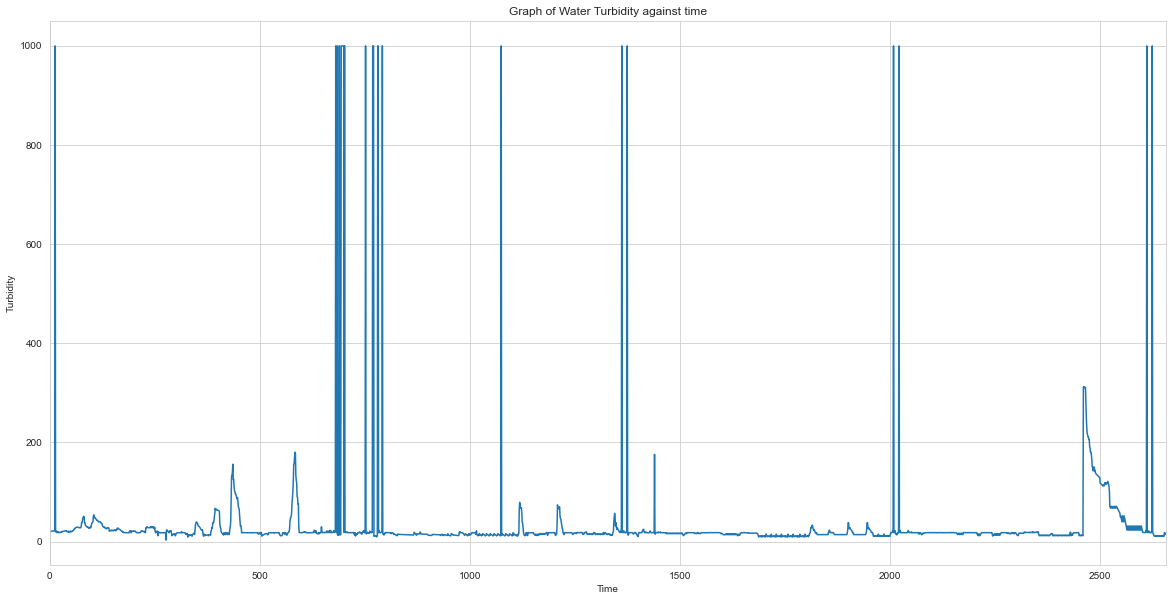

In [4]:
f1 = plt.figure(figsize=(20,10))
df_turbidity['turbidity'].plot()
plt.xlabel("Time")
plt.ylabel("Turbidity")
plt.title('Graph of Water Turbidity against time')
plt.show()

### Change timestamp to epoch.

In [5]:
epoch = pd.to_datetime(df_turbidity['time']).values.astype(np.int64)
df_turbidity['time'] = epoch

In [6]:
# Convert dataframe to array.
X = np.array(df_turbidity)

In [7]:
# Set values of axis x for plotting.
x = np.array(df_turbidity['time'])

In [8]:
# Set values of axis y for plotting.
y = np.array(df_turbidity['turbidity'])

In [9]:
%%time
#ExtensionLevel=0 is the same as regular Isolation Forest
F0 = iso.iForest(X , ntrees=100, sample_size=128, ExtensionLevel=0) # changed ntrees from 100 to 50, and sample_size from 256 to 64 

Wall time: 780 ms


In [10]:
%%time
# F1 is the Extended Isolation Forest with extension 1, which is the fully extended case.
F1 = iso.iForest(X , ntrees=100, sample_size=128, ExtensionLevel=1) # changed ntrees from 100 to 50, and sample_size from 256 to 64 


Wall time: 871 ms


In [11]:
%%time
# Function compute_paths returns that anomaly score. It computes the depth each points
# reaches in each trained tree, and converts the ensemble aggregate to an anomaly score.


# Score the training data itself to see the distribution of
# the anomaly scores each point receives.
S0 = F0.compute_paths(X_in=X)


Wall time: 18.3 s


In [12]:
%%time
S1 = F1.compute_paths(X_in=X) 


Wall time: 18.2 s


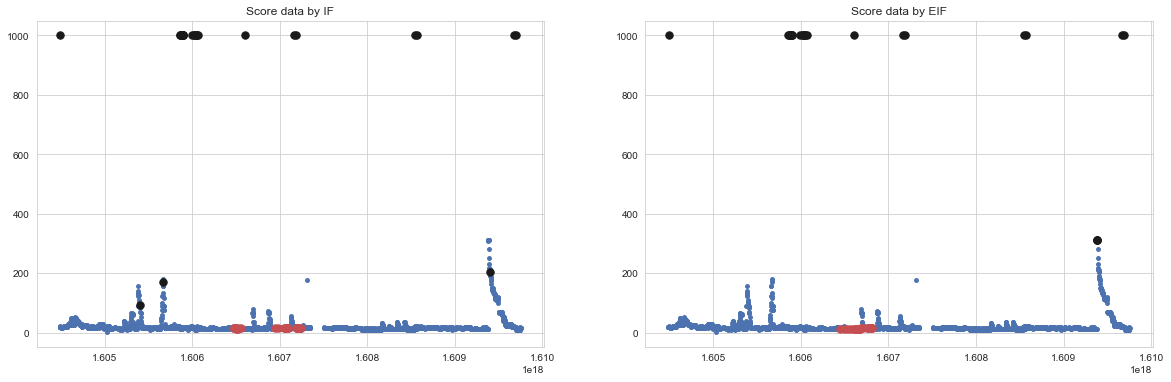

In [13]:
# Plot the points and highlight 30 points with highest and 30 points with lowest anomaly
# scores. The two plots provide a comparison between the two algorithms.

ss0=np.argsort(S0)
ss1=np.argsort(S1)
f = plt.figure(figsize=(20,6))   # changed from (12,6) to (20,6)
plt.subplot(1,2,1)
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[ss0[-30:]],y[ss0[-30:]],s=55,c='k')
plt.scatter(x[ss0[:30]],y[ss0[:30]],s=55,c='r')
plt.title('Score data by IF')
plt.subplot(1,2,2)
plt.scatter(x,y,s=15,c='b',edgecolor='b')
plt.scatter(x[ss1[-30:]],y[ss1[-30:]],s=55,c='k')
plt.scatter(x[ss1[:30]],y[ss1[:30]],s=55,c='r')
plt.title('Score data by EIF')
plt.show()


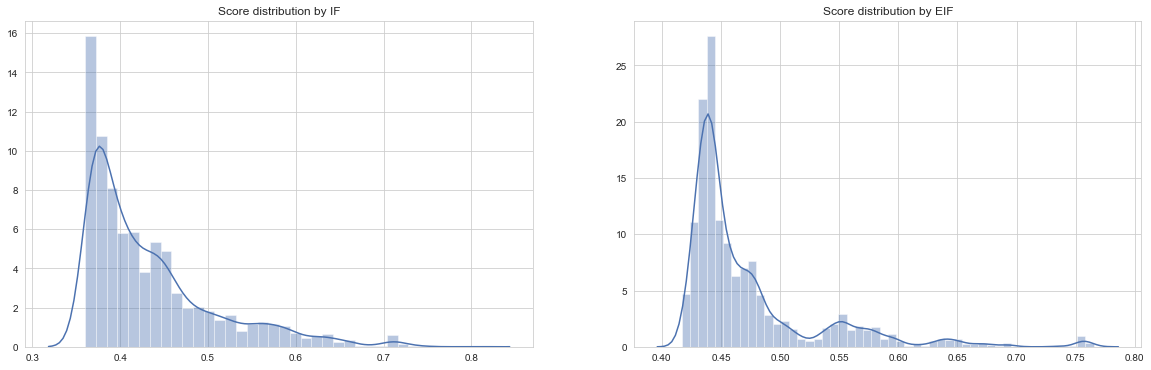

In [14]:
#The plotting above shows that standard IF works better than EIF and found more anomalies.
#Some point anomalies were missed by EIF.


f = plt.figure(figsize=(20,6)) #changed from (12,6) to (20,6)
plt.subplot(1,2,1) 
sb.distplot(S0, kde=True, color="b")
plt.title('Score distribution by IF')

plt.subplot(1,2,2)
sb.distplot(S1, kde=True, color="b")
plt.title('Score distribution by EIF')
plt.show()


In [15]:
#A meshgrid is created on a square domain. Each point on the grid is then scored using the
#trained forests. The resulting score map is visualized using contour plots.

xx, yy = np.meshgrid(np.linspace(-5, 30, 30), np.linspace(-3, 3, 30))

S0 = F0.compute_paths(X_in=np.c_[xx.ravel(), yy.ravel()])
S0 = S0.reshape(xx.shape)

S1 = F1.compute_paths(X_in==np.c_[xx.ravel(), yy.ravel()])
S1 = S1.reshape(xx.shape)

f = plt.figure(figsize=(12,6))
ax1 = f.add_subplot(121)

levels = np.linspace(np.min(S0),np.max(S0),10)
CS = ax1.contourf(xx, yy, S0, levels, cmap=plt.cm.YlOrRd)

plt.scatter(x,y,s=15,c='None',edgecolor='k')
plt.title('Score map by IF')

ax2 = f.add_subplot(122)
levels = np.linspace(np.min(S1),np.max(S0),10)
CS = ax2.contourf(xx, yy, S1, levels, cmap=plt.cm.YlOrRd)
plt.scatter(x,y,s=15,c='None',edgecolor='k')
plt.title('Score map by EIF')
plt.show()

ValueError: operands could not be broadcast together with shapes (2,) (3,) 

In [16]:
#The following code is used to get a meaningful threshold to distinguish anomalies and normal data

In [17]:
anomalies0 = S0[S0 > 0.7]
anomalies0.size

28

In [18]:
anomalies1 = S1[S1 > 0.7]
anomalies1.size

27

In [19]:
anomalies0 = S0[S0 > 0.65]
anomalies0.size

47

In [20]:
anomalies1 = S1[S1 > 0.65]
anomalies1.size

58

In [21]:
#This visualization provides a quick view of how an average anomalous points reaches much
#lower depths than the normal points.

Sorted=False
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot(121, projection='polar')
rn, thetan = getVals(F0,np.array([0,0]),sorted=Sorted)
for j in range(len(rn)):
    ax1.plot([thetan[j],thetan[j]], [1,rn[j]], color='b',alpha=1,lw=1)
ra, thetaa = getVals(F0,np.array([3.3,3.3]),sorted=Sorted)
    for j in range(len(ra)):
ax1.plot([thetaa[j],thetaa[j]], [1,ra[j]], color='r',alpha=0.9,lw=1.3)
title ="Forest visualization by IF\nNominal: Mean={0:.3f}, Var={1:.3f}\n" + \
"Anomaly: Mean={2:.3f}, Var={3:.3f}"
ax1.set_title(title.format(np.mean(rn),np.var(rn),np.mean(ra),np.var(ra)))
ax1.set_xticklabels([])
ax1.set_xlabel("Anomaly")
ax1.set_ylim(0,F0.limit)
ax1.axes.get_xaxis().set_visible(False)
ax1.axes.get_yaxis().set_visible(False)
ax2 = plt.subplot(122, projection='polar')
rn, thetan = getVals(F1,np.array([0,0]),sorted=Sorted)
    for j in range(len(rn)):
ax2.plot([thetan[j],thetan[j]], [1,rn[j]], color='b',alpha=1,lw=1)
ra, thetaa = getVals(F1,np.array([3.3,3.3]),sorted=Sorted)
    for j in range(len(ra)):
ax2.plot([thetaa[j],thetaa[j]], [1,ra[j]], color='r',alpha=0.9,lw=1.3)
title ="Forest visualization by EIF \nNominal: Mean={0:.3f}, Var={1:.3f}\n" + \
"Anomaly: Mean={2:.3f}, Var={3:.3f}"
ax2.set_title(title.format(np.mean(rn),np.var(rn),np.mean(ra),np.var(ra)))
ax2.set_xticklabels([])
ax2.set_xlabel("Anomaly")
ax2.set_ylim(0,F0.limit)
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

IndentationError: unexpected indent (<ipython-input-21-2ff466171ed8>, line 11)